# MNIST Convnet
This algorithm provides a quick visualization of the layers of a convolutional network

The MNIST data used here can be found at https://www.kaggle.com/c/digit-recognizer/data

In [1]:
# Array manipulation
import numpy as np

# Import and visualize data
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
# TENSORFLOOOOW
import tensorflow as tf

# Train/validation split
from sklearn.model_selection import train_test_split

Data parameters

In [2]:
image_size = 28
image_depth = 1
num_labels = 10
# Number of color channels
n_input = 1

Hyper parameters

In [3]:
# Filters specifications
n_filters = [16, 32, 32]
filter_sizes = [5, 5, 3]

# Fully connected layers
layer_shapes = [1024]

# Train
batch_size = 128
epochs = 20001
prob_keep = 0.75
learning_rate = 1e-4

Restore previous session

In [4]:
restore = False
restore_path = '../Digit_Recognizer/variables/conv.ckpt'

# Load data

In [5]:
# Load train dataset
load_train = pd.read_csv('input/train.csv').as_matrix()
X_train = load_train[:, 1:]
Y_train = load_train[:, 0]
# Load test dataset
X_test = pd.read_csv('input/test.csv').as_matrix()

# Delete loaded arrays to free up memory
del load_train

train_samples = len(X_train)
test_samples = len(X_test)
print('Train samples: {}\nTest samples: {}'.format(train_samples, test_samples))

Train samples: 42000
Test samples: 28000


Draw a random sample

Label: 9


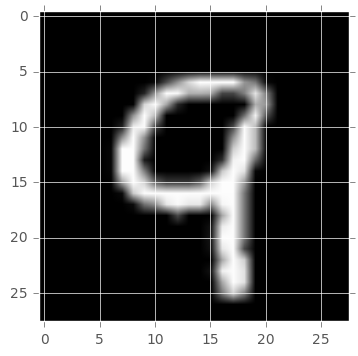

In [6]:
random_sample = np.random.randint(X_train.shape[0])
print('Label: {}'.format(Y_train[random_sample]))
plt.imshow(X_train[random_sample].reshape([image_size, image_size]), cmap = 'gray')

One hot Y

In [7]:
Y_onehot = np.zeros([train_samples, num_labels])
Y_onehot[np.arange(train_samples), Y_train] = 1

# Verify one hot on a sample
print('Original label: {}\nOne hot label: {}'.format(Y_train[42], Y_onehot[42]))

Original label: 4
One hot label: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


Make a train/validation split

In [8]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_onehot, test_size = 0.005)

Reshape the data, a 4-D array is needed convolution

In [9]:
def reshape_data(data):
    return np.reshape(data, [-1, image_size, image_size, image_depth])

In [10]:
X_train = reshape_data(X_train)
X_valid = reshape_data(X_valid)
X_test = reshape_data(X_test)

print('Train shape:{}\nValidation shape:{}\nTest shape:{}'.format(X_train.shape, X_valid.shape, X_test.shape))

Train shape:(41790, 28, 28, 1)
Validation shape:(210, 28, 28, 1)
Test shape:(28000, 28, 28, 1)


In [11]:
def layer_shape(layer):
    layer_shape = layer.get_shape().as_list()    
    return layer_shape

# Build the network

In [12]:
# Input placeholders
X = tf.placeholder(name='input' ,dtype=tf.float32, shape=[None, image_size, image_size, image_depth])
Y = tf.placeholder(name='labels', dtype=tf.float32, shape=[None, num_labels])

# Keep probability (Dropout)
keep_prob = tf.placeholder(name='keep_prob', dtype=tf.float32)

Make convolutional layers

In [13]:
# Input layer of the network
current_input = X

# Use a loop for creating conv layers
for filter_i, n_output in enumerate(n_filters):
    # Use scope for better indentification of graph
    with tf.variable_scope('conv/filter/{}'.format(filter_i)):
        # Create weights
        W = tf.get_variable(
            name='W',
            shape=[filter_sizes[filter_i], filter_sizes[filter_i], n_input, n_output],
            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            initializer=tf.constant_initializer())
        
        # Convolve image
        h = tf.nn.conv2d(
            input=current_input,
            filter=W,
            strides=[1, 1, 1, 1],
            padding='SAME')
        
        # Add bias
        h = tf.nn.bias_add(
            name='add_bias',
            value=h,
            bias=b)
        
         # Add pooling
        h = tf.nn.max_pool(
            name='pre_relu_pool',
            value=h,
            ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            padding='SAME')
        
        # Add ReLU
        h = tf.nn.relu(h)      
        
        # Update current input
        current_input = h
        n_input = n_output

Flatten layer

In [14]:
current_shape = layer_shape(current_input)
print('Last layer shape: {}'.format(current_shape))

Last layer shape: [None, 4, 4, 32]


In [15]:
current_input = tf.reshape(current_input, [-1, current_shape[1] * current_shape[2] * current_shape[3]])

In [16]:
current_shape = layer_shape(current_input)
print('Last layer shape: {}'.format(current_shape))

Last layer shape: [None, 512]


Make fully connected layers

In [17]:
n_input = current_shape[1]

for layer_i, n_output in enumerate(layer_shapes):
    # Use a scope
    with tf.variable_scope('fully_connected/layer/{}'.format(layer_i)):
        # Create weight
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.contrib.layers.xavier_initializer())     
        # Create bias
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            initializer=tf.constant_initializer())
        
        # Compute output
        h = tf.matmul(current_input, W) + b
        
        # Add non linearity
        h = tf.nn.relu(h)
        
        # Add dropout
        h = tf.nn.dropout(h, keep_prob)
        
        # Update current input
        current_input = h
        n_input = n_output

In [18]:
current_shape = layer_shape(current_input)
print('Last layer shape: {}'.format(current_shape))

Last layer shape: [None, 1024]


In [19]:
knn_layer = current_input

Final layer

In [20]:
n_input = current_shape[1]

# Use scope
with tf.variable_scope('final_layer'):
    # Create weights
    W = tf.get_variable(
        name='W',
        shape=[n_input, num_labels],
        initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05))
    # Create bias
    b = tf.get_variable(
        name='b',
        shape=[num_labels],
        initializer=tf.constant_initializer())
    
    # Compute output
    logits = tf.matmul(current_input, W) + b
    # Aplly softmax
    pred = tf.nn.softmax(logits)

In [21]:
current_shape = layer_shape(pred)
print('Last layer shape: {}'.format(current_shape))

Last layer shape: [None, 10]


Compute cost

In [22]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, Y))

In [23]:
# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Train

In [24]:
accuracy = tf.reduce_mean( (tf.cast(tf.equal(tf.argmax(Y, 1), tf.argmax(pred, 1)), dtype=tf.float32)) )

In [25]:
# Start a interactive session
sess = tf.InteractiveSession()
# Initiliaze all variables
tf.initialize_all_variables().run()
# Create a saver
saver = tf.train.Saver()

# Keep track of costs
costs = []

# Restore previous session
if restore == True:
    saver.restore(sess, restore_path)

In [26]:
for epoch in range(epochs):
    # Get a random batch
    rand_idx = np.random.choice(X_train.shape[0], size=batch_size, replace=False)
    batch_X = X_train[rand_idx]
    batch_Y = Y_train[rand_idx]
    
    # Train
    sess.run(optimizer, feed_dict = {X : batch_X, Y : batch_Y, keep_prob : prob_keep})
    
    if epoch % 200 == 0:
        # Compute cost on training batch
        current_cost = cost.eval(feed_dict={X : batch_X, Y : batch_Y, keep_prob : 1})
        print('Step: {} | Cost: {}'.format(epoch, current_cost))
        costs.append(current_cost)
        # Compute accuracy on training batch and validation set
        pred_train = accuracy.eval(feed_dict = {X : batch_X, Y : batch_Y, keep_prob : 1})
        pred_valid = accuracy.eval(feed_dict = {X : X_valid, Y : Y_valid, keep_prob : 1})
        print('Accuracy on train set: {}'.format(pred_train))
        print('Accuracy on validation set: {}'.format(pred_valid))
        print('---------------------------------------------------------------------------')
        
        # Save variables
        if epoch % 1000 == 0:
            save_path = saver.save(sess, "variables/conv{}.ckpt".format('_'.join([str(a) for a in n_filters])))
            print('===========================================================================')
            print("Model saved in file: {}".format(save_path))
            print('===========================================================================')

Step: 0 | Cost: 27.47435188293457
Accuracy on train set: 0.1875
Accuracy on validation set: 0.12857143580913544
---------------------------------------------------------------------------
Model saved in file: variables/conv16_32_32.ckpt
Step: 200 | Cost: 0.2781961262226105
Accuracy on train set: 0.8828125
Accuracy on validation set: 0.938095211982727
---------------------------------------------------------------------------
Step: 400 | Cost: 0.2053125947713852
Accuracy on train set: 0.953125
Accuracy on validation set: 0.9666666388511658
---------------------------------------------------------------------------
Step: 600 | Cost: 0.1567433625459671
Accuracy on train set: 0.9765625
Accuracy on validation set: 0.9714285731315613
---------------------------------------------------------------------------
Step: 800 | Cost: 0.0453583300113678
Accuracy on train set: 0.984375
Accuracy on validation set: 0.9714285731315613
----------------------------------------------------------------------

In [27]:
# Predict test set on batches (Insufficient memory to predict all at once)
print('Predicting test set...')
pred_tests = np.array([])
n_batches = len(X_test) // 1000
for batch_i in range(n_batches):
    pred_test = np.argmax(pred.eval(feed_dict = {X : X_test[1000*batch_i : 1000*(batch_i+1)], keep_prob : 1}), 1)
    pred_tests = np.hstack((pred_tests, pred_test))
print('Done!')

Predicting test set...
Done!


Plot cost

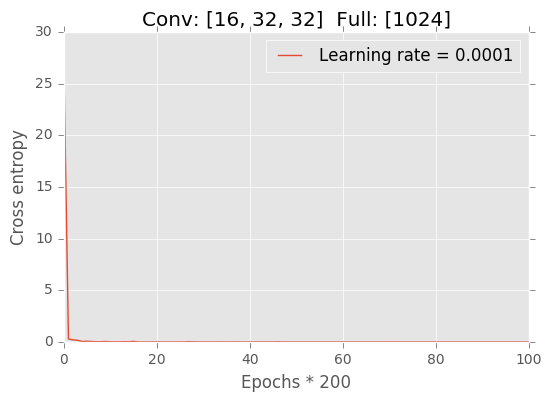

In [28]:
plt.plot(costs)
plt.title('Conv: {}  Full: {}'.format(n_filters ,layer_shapes))
plt.ylabel('Cross entropy')
plt.xlabel('Epochs * 200')
plt.legend(('Learning rate = {}'.format(learning_rate),))
plt.savefig('Conv{}filter_size{}_{}.png'.format(n_filters, filter_sizes, learning_rate))

# Make submission file

In [29]:
np.savetxt(
    'pred_{}{}_filtersize_{}.csv'.format(learning_rate, n_filters, filter_sizes),
     np.c_[np.arange(1, len(X_test)+1), pred_tests],
     fmt='%i,%i',
     header='ImageId,Label',
     comments='')

# Visualizing Weights

In [30]:
g = tf.get_default_graph()

In [31]:
[op.name for op in g.get_operations()]

['input',
 'labels',
 'keep_prob',
 'conv/filter/0/W',
 'conv/filter/0/W/Initializer/random_uniform/shape',
 'conv/filter/0/W/Initializer/random_uniform/min',
 'conv/filter/0/W/Initializer/random_uniform/max',
 'conv/filter/0/W/Initializer/random_uniform/RandomUniform',
 'conv/filter/0/W/Initializer/random_uniform/sub',
 'conv/filter/0/W/Initializer/random_uniform/mul',
 'conv/filter/0/W/Initializer/random_uniform',
 'conv/filter/0/W/Assign',
 'conv/filter/0/W/read',
 'conv/filter/0/b',
 'conv/filter/0/b/Initializer/Const',
 'conv/filter/0/b/Assign',
 'conv/filter/0/b/read',
 'conv/filter/0/Conv2D',
 'conv/filter/0/add_bias',
 'conv/filter/0/pre_relu_pool',
 'conv/filter/0/Relu',
 'conv/filter/1/W',
 'conv/filter/1/W/Initializer/random_uniform/shape',
 'conv/filter/1/W/Initializer/random_uniform/min',
 'conv/filter/1/W/Initializer/random_uniform/max',
 'conv/filter/1/W/Initializer/random_uniform/RandomUniform',
 'conv/filter/1/W/Initializer/random_uniform/sub',
 'conv/filter/1/W/Initia

Convolutional layers

In [32]:
# Store every conv layer weight on W_conv
W_conv = []
activations = []
for i in range(len(n_filters)):
    # Get weights
    W = g.get_tensor_by_name('conv/filter/{}/W:0'.format(i))
    W_conv.append(W.eval())
    # Get layer activations
    activation = g.get_tensor_by_name('conv/filter/{}/pre_relu_pool:0'.format(i))
    activations.append(activation.eval(feed_dict={X:X_valid}))

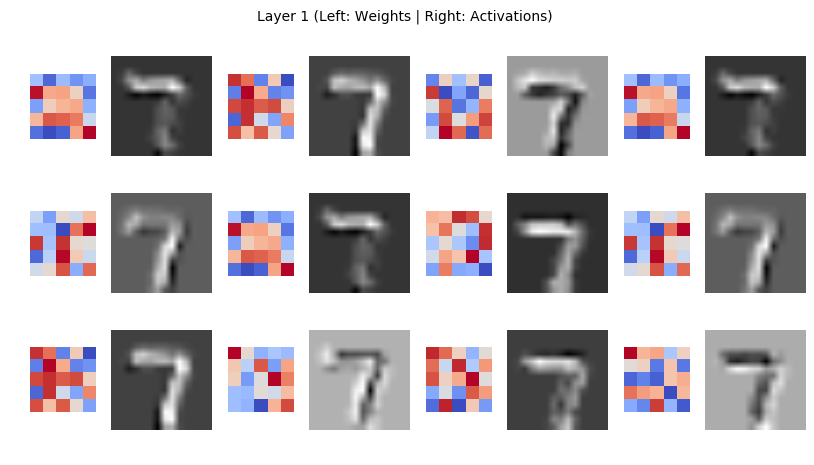

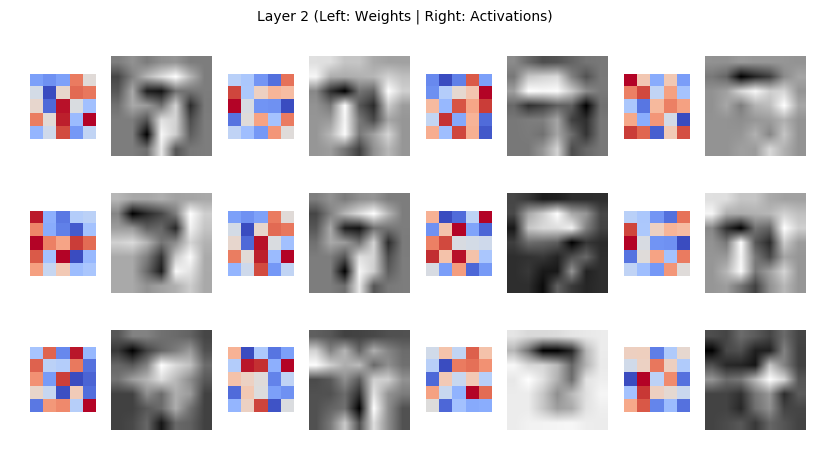

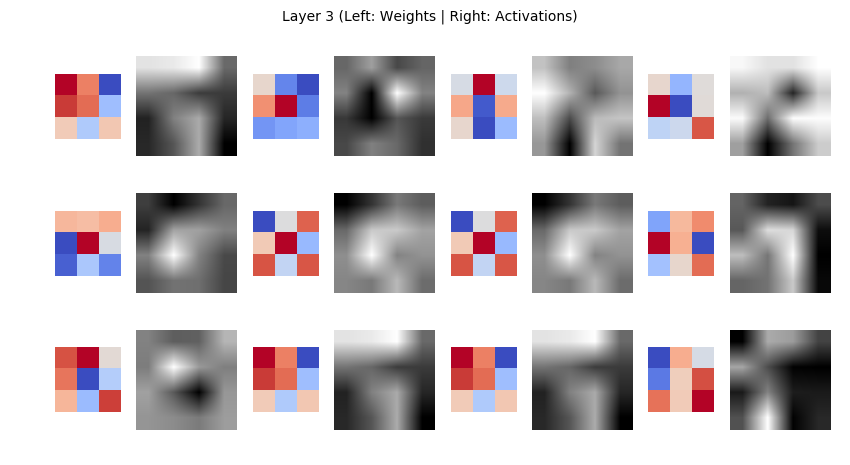

In [33]:
# Get a random image to plot
rand_image_idx = np.random.randint(activations[0].shape[0])

# Plot for all conv layers
for n in range(len(n_filters)):   
    # Normalize weights
    W_current = W_conv[n]
    W_current = (W_current / np.max(np.abs(W_current))) * 128 + 128
    
    # Create subplots
    fig, axs = plt.subplots(3, 8, figsize=(10, 5), gridspec_kw={'width_ratios':[1.3, 2, 1.3, 2, 1.3, 2, 1.3, 2]})
    # Populate subplots
    for i, ax in enumerate(axs.flat):
        if i % 2 == 0:
            # Pick a random filter to display
            rand_filter = np.random.randint(W_conv[n].shape[3])
            ax.imshow(W_current[:, :, 0, rand_filter], cmap='coolwarm', interpolation='nearest')
        else:
            # Plot activations
            ax.imshow(activations[n][rand_image_idx, :, :, rand_filter], cmap='gray')

        # Set title for each plot
        plt.suptitle('Layer {} (Left: Weights | Right: Activations)'.format(n+1))
        # Remove grid and ticks
        ax.axis('off')

Layer Gradients

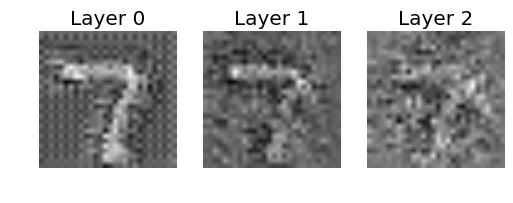

In [83]:
# Get the most activate neuron of each layer and find its gradient
input_layer = g.get_tensor_by_name('input:0')

# Make subplots
fig, axs = plt.subplots(1, len(n_filters))
for layer_i, ax in enumerate(axs.flat):    
    activation = g.get_tensor_by_name('conv/filter/{}/pre_relu_pool:0'.format(layer_i))
    # Get the most active neuron and calculate its gradient with respect to the input
    gradient = tf.gradients(tf.reduce_max(activation, 3), input_layer)
    res = sess.run(gradient, feed_dict={X:X_valid})[0]
    # Plot the gradient
    res = np.squeeze(res)
    ax.imshow(res[rand_image_idx], cmap='gray')
    ax.set_title('Layer {}'.format(layer_i))    
    ax.axis('off')

Generate a image that maximes a layer activation

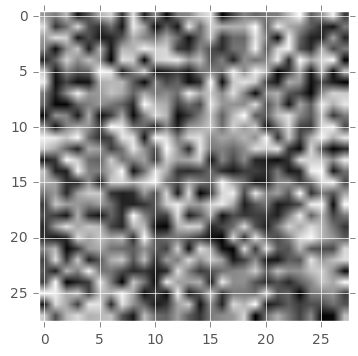

In [72]:
# Generate a random noisy image
def noisy_image():
    return np.random.uniform(size=[image_size, image_size]) + 128
img = noisy_image()
plt.imshow(img, cmap='gray')

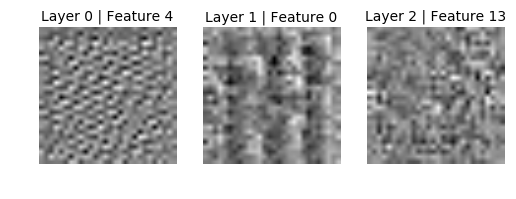

In [96]:
# Number of times to optimize each image
n_iterations = 50

fig, axs = plt.subplots(1, 3)
for layer_i in range(len(n_filters)): 
    # Generate a noisy image
    img = noisy_image()
    # Get the layer and a random feature to maxime
    layer = g.get_tensor_by_name('conv/filter/{}/pre_relu_pool:0'.format(layer_i))
    feature = np.random.randint(layer.get_shape().as_list()[-1])
    activation = tf.reduce_mean(layer[:, :, :, feature])
    # Get the gradient of that feature in respect to the input image
    gradient = tf.gradients(activation, input_layer)

    for _ in range(n_iterations):
        # Resize the image to 4-D
        resized_img = reshape_data(img)
        # Compute gradient
        prediction, grad, act = sess.run([pred, gradient, activation], feed_dict={X:resized_img, keep_prob:1})

        # Remove singleton dimensions
        grad = np.squeeze(grad)
        # Step size for updating the image (for faster convergence)
        step_size = 1.0 / (grad.std() + 1e-8)
        # Add gradient to image
        img += step_size * grad
        # Make sure values are between 0=255
        img = np.clip(img, 0, 255)   

    axs[layer_i].imshow(img, cmap='gray')
    axs[layer_i].set_title('Layer {} | Feature {}'.format(layer_i, feature), fontsize=10)
    axs[layer_i].axis('off')